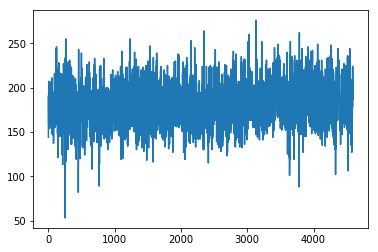

average = 36.37366309777444
coverage = 0.9999991815093132


In [2]:
#Genome coverage (graph, percentage of genome covered, average coverage)

import pysam
import pyBigWig
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

bw_1000_f = 'C24-698_1000_bwamem.bw'
bw_1_f = 'C24-698_bwamem.bw'
bam_f = 'C24-698_bwamem.sorted.bam'
#C24-698
#C24-698_bwamem

bw_1000 = open('/Users/dashabalashova/ngs_institute/HW2/'+bw_1000_f, 'r')
a = []
for r in bw_1000.read().splitlines():
    a.append(int(r.split('\t')[-1]))

plt.figure()
plt.plot(a)
plt.show()

bw = open('/Users/dashabalashova/ngs_institute/HW2/'+bw_1_f, 'r')
a = []
for r in bw.read().splitlines():
    a.append(int(r.split('\t')[-1]))

print('average =', np.mean(a))
print('coverage =', (len(a)-a.count(0))/len(a))

In [69]:
#Table of frequencies of replacements / insertions / deletions and and lengths of indels hist


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


bamfile = pysam.AlignmentFile(bam_f, 'rb')

a = np.array([[0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0],
              [0,0,0,0,0]])

frame = pd.DataFrame(a, index=['A','C','G','T','-'], columns=['A','C','G','T','-'])

N = 0
indel = []

insertion_s = ''
deletion_s = ''
mism_read_s = ''
mism_ref_s = ''
indels_lengths = []
for alignment in bamfile.fetch():
    if (str(alignment).split()[5])!='None':
        read = alignment.query_sequence
        ref = alignment.get_reference_sequence()
        mapping = alignment.get_aligned_pairs(matches_only=True, with_seq=True)
        n_read = 0
        n_ref = 0
        
        for i in alignment.cigar:
            
            if i[0]==4: #start_insertion
                insertion_s += read[n_read:n_read+i[1]]
                indels_lengths.append(i[1])
                n_read += i[1]
            
            if i[0]==0: #match
                for n in range(0,i[1]):
                    if ref[n_ref:n_ref+i[1]][n].islower()==True:
                        mism_read_s+=read[n_read:n_read+i[1]][n]
                        mism_ref_s+=ref[n_ref:n_ref+i[1]][n]
                n_read += i[1]
                n_ref += i[1]
                         
            if i[0]==1: #BAM_CINS
                insertion_s += read[n_read:n_read+i[1]]
                indels_lengths.append(i[1])
                n_read += i[1]
                
            if i[0]==2: #BAM_CDEL
                deletion_s += ref[n_ref:n_ref+i[1]]
                indels_lengths.append(i[1])
                n_ref += i[1]
                             
                
for n in range(0,len(mism_read_s)):
    frame[mism_ref_s[n].upper()][mism_read_s[n]] += 1       

for i in insertion_s:
    frame['-'][i] += 1
    
for i in deletion_s:
    frame[i]['-'] += 1
    
    
frame

,A,C,G,T,-
A,0,6751,14257,6549,220153
C,5124,0,4978,22450,180769
G,21938,5380,0,5248,179672
T,6488,13966,7069,0,220640
-,37199,82132,82142,37728,0


In [70]:
import pandas as pd

pd.value_counts(indels_lengths).to_frame().reset_index()

,index,0
0,1,437534
1,2,31921
2,3,8077
3,7,3444
4,8,3400
5,5,3137
6,9,3012
7,6,2908
8,10,2743
9,4,2666


In [71]:






#Статистика дин инделов в завимости от длины гомополимерного участка на примере 'AAAAA'

import pysam
import re


def find(sst, st):
    st = st.upper()
    u = [m.start() for m in re.finditer(sst, st)]
    u2 = []
    for n in range(0,len(u)):      
        if u[n]+len(sst)>=len(st):
            u2.append(u[n])
        elif st[u[n]+len(sst)]!=sst[0]:
            u2.append(u[n])
    return u2

def map_f(mapping, read, position, sst):
    u=[]
    R = mapping[0][1]
    for m in mapping:
        if m[1] in range(position+R, position+len(sst)+R):
            u.append(m[0])
    if u==[]:
        return 'N'
    s1 = 0
    s2 = 0
    while (max(u)+1<len(read) and s1==0):
        if read[max(u)+1]==gomo[0]:
            u.append(max(u)+1)
        else:
            s1=1
    while (min(u)-1>=0 and s2==0):
        if read[min(u)-1]==gomo[0]:
            u.append(min(u)-1)
        else:
            s2=1           
    return read[min(u):max(u)+1] 

def ch(st):
    n=25
    while n>0:
        if st.count('A'*n)>0:
            return 'A'*n
        else:
            n-=1
    return ''

samfile = pysam.AlignmentFile(bam_f, "rb")
n=0
g_arr = []
for alignment in samfile.fetch():
    if 1>0:
        gomo = 'AAAAA'
        mapping = alignment.get_aligned_pairs(matches_only=True, with_seq=True)
        read = alignment.query_sequence
        ref = alignment.get_reference_sequence()
        
       
        for p in find(gomo, ref):
            a = map_f(mapping, read, p, gomo)
            g_arr.append(ch(a))    
        n+=1
    else:
        break
        

for a in set(g_arr):
    if a!='':
        print(a, g_arr.count(a))

AAAAAAAAAAAAAAAAAAAAA 3
AAAAAAAAAA 4
AAAAAAAAAAA 5
AA 54
AAAAAA 2423
AAA 189
AAAA 5091
AAAAAAAAAAAAAAAA 4
AAAAAAAAAAAAAA 2
AAAAAAAAAAAAAAAAA 3
AAAAAAAAAAAAA 7
AAAAAAAAAAAA 4
AAAAAAAAAAAAAAA 2
AAAAAAA 47
AAAAAAAAA 7
AAAAAAAAAAAAAAAAAAAAAA 3
AAAAA 204248
AAAAAAAA 28


In [ ]:
#Средний процент ошибок в ридах, Статистика качества нуклеотидов при ошибочно вставленном нуклеотиде и при замене

import pysam
import matplotlib.pyplot as plt
import numpy as np

samfile = pysam.AlignmentFile(bam_f, "rb")
g_arr = []

qual_MIS_num = []
qual_I_num = []
insertion_rate = []
mismatch_rate = []

for alignment in samfile.fetch():
    if 0<1:
        read = alignment.query_sequence
        quality = alignment.qual
        ref = alignment.get_reference_sequence()
        count_I = 0
        qual_I = ''
        count_MIS = 0
        qual_MIS = ''
        i_n = 0
        for i in alignment.cigar:
            if i[0]==1:
                count_I+=i[1]
                qual_I += quality[i_n:i_n+i[1]]
            i_n += i[1] 

        i_n = 0
        for i in alignment.get_aligned_pairs(matches_only=True, with_seq=True):
            if i[2].islower() == True:
                count_MIS+=1
                qual_MIS_num.append(10**-((ord(quality[i_n])-33)/10.0))
            i_n += 1
            
        for i in qual_I:
            qual_I_num.append(10**-((ord(i)-33)/10.0))
            
        insertion_rate.append(count_I/len(read))
        mismatch_rate.append(count_MIS/len(read))

        

plt.figure(1)
plt.hist(qual_I_num, rwidth = 2, alpha = 0.5, label = "insertions qualities") 
plt.hist(qual_MIS_num, rwidth = 2, alpha = 0.5, label = "mismatch qualities")
plt.legend(loc = 'upper right')
plt.show()
        
print('insertion mean percent =', "{0:.2%}".format(np.mean(insertion_rate)))
print('mismatch mean percent =', "{0:.2%}".format(np.mean(mismatch_rate)))